# Loading the data

In [ ]:
import numpy as np

In [ ]:
dataset = np.load("/content/drive/MyDrive/1.npy")

In [ ]:
dataset.shape

(259520, 65)

In [ ]:
dataset = dataset[dataset[:,-1]!=10,:]

# Convert your dataset into `segments`

In [ ]:
def extract(input, n_classes, n_fea, time_window, moving):
    xx = input[:, :n_fea]
    yy = input[:, n_fea:n_fea + 1]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes + 1):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [ ]:
data = extract(dataset ,10 ,64 ,16 ,8)

# How to Divide Data into Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split
n_fea = 64
time_window = 16
no_longfeature = n_fea * time_window
data_seg_feature = data[:, :no_longfeature]
data_seg_label = data[:, no_longfeature:no_longfeature+1]
train_feature, test_feature, train_label, test_label = train_test_split(data_seg_feature, data_seg_label,test_size=0.2, shuffle=True)

In [ ]:
train_feature.shape

(13754, 1024)

In [ ]:
test_feature.shape

(3439, 1024)

# Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler().fit(train_feature)
train_fea_norm1 = scaler1.transform(train_feature) # normalize the training data
test_fea_norm1 = scaler1.transform(test_feature) # normalize the test data

# Building a CNN Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(2,4),
                stride=1,
                padding= (1,2)  #([1,2]-1)/2,
            ),
            nn.ReLU(),
            nn.MaxPool2d((2,4))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, (2,2), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )


        self.fc = nn.Linear(1024, 128)  # 64*2*4
        self.out = nn.Linear(128, n_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = F.dropout(x, p=0.2)
        output = self.out(x)
        return output

In [ ]:
BATCH_size = 100
n_class = 10

# Training your CNN Network

In [ ]:
n_class=10
cnn = CNN()
# let's pass an input to it
input = torch.randn(BATCH_size, 1, 16, 64)
output = cnn(input)

In [ ]:
cnn = CNN()
# lets test out network by passing noise to it  as input
import time
start_time = time.perf_counter()




device = "cuda" if torch.cuda.is_available() else "cpu"
cnn.to(device)
LR = 0.001
l2 = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay=l2)
loss_func = nn.CrossEntropyLoss()

In [ ]:
segment_length = 16
no_feature = 64

train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])

In [ ]:
train_label.shape

torch.Size([13754])

In [ ]:
BATCH_size = 10000

In [ ]:
import torch.utils.data as Data

# feed data into dataloader
train_fea_norm1 = torch.tensor(train_fea_norm1)
train_fea_norm1 = torch.unsqueeze(train_fea_norm1, dim=1).type('torch.FloatTensor').to(device)

train_label = torch.tensor(train_label.flatten()).to(device)
train_data = Data.TensorDataset(train_fea_norm1, train_label)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

test_fea_norm1 = torch.tensor(test_fea_norm1)
test_fea_norm1 = torch.unsqueeze(test_fea_norm1, dim=1).type('torch.FloatTensor').to(device)
test_label = torch.tensor(test_label.flatten()).to(device)

<ipython-input-95-045884f90211>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_label = torch.tensor(train_label.flatten()).to(device)
<ipython-input-95-045884f90211>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_label = torch.tensor(test_label.flatten()).to(device)


In [ ]:
# training and testing
for epoch in range(300):
    for step, (train_x, train_y) in enumerate(train_loader):
        output = cnn(train_x)  # CNN output of training data
        loss = loss_func(output, train_y.long())  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

    if epoch % 10 == 0:
        test_output = cnn(test_fea_norm1)  # CNN output of test data
        test_loss = loss_func(test_output, test_label.long())

        print(test_loss.item())

1.796826958656311
1.7799025774002075
1.7696937322616577
1.738603115081787
1.7167158126831055
1.7167805433273315
1.6981024742126465
1.6887787580490112
1.6781927347183228
1.6606149673461914
1.6487207412719727
1.6392347812652588
1.6094380617141724
1.619462490081787
1.6242471933364868
1.5696234703063965
1.5859625339508057
1.5675662755966187
1.5373221635818481
1.5261507034301758
1.5166313648223877
1.5312525033950806
1.5160479545593262
1.5059423446655273
1.4952983856201172
1.5000404119491577
1.4963592290878296
1.4836511611938477
1.4667428731918335
1.4684884548187256


Confusion Matrix:
[[131   4  34  22  20  19   9   3  12  15]
 [  1 197   6   3   1   3   1   1   5   7]
 [ 16   8 230  44  14  13  15  23  13  17]
 [ 17   9  83 168   7  18  19  26  10  19]
 [ 26   6  37  14 173  51  12   9  17  24]
 [ 25   2  36  15  53 143  14   9  17  24]
 [ 18   4  46  34  14  15 150  33  25  31]
 [  7   3  43  20  12  11  37 169  16  21]
 [ 24  13  40  13  21  17  33  15 121  57]
 [ 13  13  38  12  16  16  15  32  41 210]]


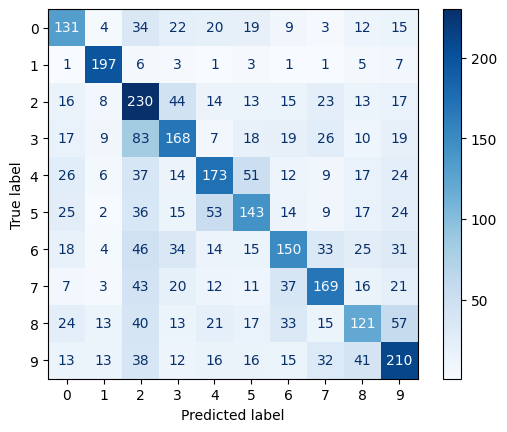

In [ ]:
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay

true_y = test_label.data.cpu().numpy()
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()

# Create confusion matrix
conf_matrix = confusion_matrix(true_y, pred_y)
print("Confusion Matrix:")
print(conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

# loading data

In [1]:
import scipy.io as sc
import numpy as np
from sklearn import preprocessing

data = np.load(open('/content/drive/MyDrive/all_01.dat', 'rb'),allow_pickle=True)

In [2]:
EEG = preprocessing.minmax_scale(data[:, :140], axis=1)
EEG = EEG * 2 - 1
ima = preprocessing.minmax_scale(data[:, 140:], axis=1)
ima = ima * 2 - 1
data = np.hstack((EEG, ima))

img_size = 40 * 56
EEG_size = 140

In [3]:
# Label creation
l0 = np.zeros([int(3200/5), 1])
for lab in range(1, 5):
    l_ = np.ones([int(3200/5), 1]) * lab
    l0 = np.vstack((l0, l_))

In [4]:
# Concatenate with the label and shuffle
data = np.hstack((data, l0))
np.random.shuffle(data)

# Feature extraction with CNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.fc1 = nn.Linear(64 * 2 * 3, 40) # Adjust based on the input dimensions after pooling
        self.fc2 = nn.Linear(40, 5) # Number of classes is 5

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 2 * 3) # Adjust based on the input dimensions after pooling
        x = F.dropout(x, 0.5)
        x1 = torch.sigmoid(self.fc1(x))
        x2 = self.fc2(x1)
        return x2 , x1

In [6]:
# Parameters and settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [7]:
n_class = 5
label = data[:,-1]
feature = data[:, :140]

In [8]:
data_original = data

In [9]:
n_group = 5
batch_size = int(label.shape[0]/n_group)

In [10]:
label.shape

(3200,)

In [11]:
train_fea = []

for i in range(n_group):
    f = feature[int(0+batch_size*i):int(batch_size+batch_size*i)]
    train_fea.append(f)

train_label = []
for i in range(n_group):
    f = label[int(0 + batch_size * i):int(batch_size + batch_size * i)]
    train_label.append(f)

test_fea = torch.tensor(train_fea[-1], dtype=torch.float32)
test_label = torch.tensor(train_label[-1], dtype=torch.long)

train_data = [(torch.tensor(train_fea[i], dtype=torch.float32), torch.tensor(train_label[i], dtype=torch.long)) for i in range(n_group-1)]


In [12]:
def compute_accuracy(pred, target):
    _, predicted = torch.max(pred.data, 1)
    total = target.size(0)
    correct = (predicted == target).sum().item()
    return correct / total

In [16]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 1, 10, 14)

        optimizer.zero_grad()
        outputs ,_  = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            inputs = test_fea.view(-1, 1, 10, 14).to(device)
            outputs,_ = model(inputs.to(device))
            test_loss = criterion(outputs, test_label.to(device))
            test_acc = compute_accuracy(outputs, test_label.to(device))

            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}, Test Loss: {test_loss.item()}, Test Accuracy: {test_acc}')

        if test_acc > 0.6:
            break

Epoch [0/1000], Loss: 0.44228821992874146, Test Loss: 1.311866044998169, Test Accuracy: 0.5921875
Epoch [100/1000], Loss: 0.3667462170124054, Test Loss: 1.243398904800415, Test Accuracy: 0.6078125


In [17]:
# Extract features
import pickle
model.eval()
with torch.no_grad():
    EEG_train_features_from_cnn = model(torch.tensor(train_fea,dtype=torch.float32).view(-1, 1, 10, 14).to(device))[1].cpu().numpy()
    all_new_data = np.hstack((EEG_train_features_from_cnn, data_original[:, 140:]))

    pickle.dump(all_new_data, open('EEG_feature.pkl', 'wb'))
print('dumped as shape_EEG_feature.pkl', data_original.shape, all_new_data.shape)

dumped as shape_EEG_feature.pkl (3200, 2381) (3200, 2281)


<ipython-input-17-0d0e4a0730a0>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  EEG_train_features_from_cnn = model(torch.tensor(train_fea,dtype=torch.float32).view(-1, 1, 10, 14).to(device))[1].cpu().numpy()


# Generator

In [18]:
class Generator(nn.Module):
    def __init__(self, noise_dim, n_class):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(noise_dim, 140 * 64)
        self.bn1 = nn.BatchNorm1d(140 * 64, momentum=0.9)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        #Hout​=(Hin​−1)×stride−2×padding+kernel_size+output_padding # 20
        #𝑊𝑜𝑢𝑡=(𝑊𝑖𝑛−1)×stride−2×padding+kernel_size+output_padding  # 28
        self.bn2 = nn.BatchNorm2d(32, momentum=0.9)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        #Hout​=(Hin​−1)×stride−2×padding+kernel_size+output_padding # 40
        #𝑊𝑜𝑢𝑡=(𝑊𝑖𝑛−1)×stride−2×padding+kernel_size+output_padding  # 56
        self.fc2 = nn.Linear(40 * 56, 20 * 20)
        self.fc3 = nn.Linear(20 * 20, n_class)


    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 64, 10, 14)  # Reshape to match TensorFlow's behavior
        x = F.relu(self.bn2(self.deconv1(x)))
        x = self.deconv2(x)
        logits = x.view(-1, 40 * 56)  # Flatten
        outputs = torch.tanh(logits)
        mid = torch.sigmoid(self.fc2(logits))
        pred = self.fc3(mid)
        return logits, outputs, pred

# Example usage
noise_dim = 60
n_class = 5

generator = Generator(noise_dim, n_class)
noise_img = torch.randn((64, noise_dim))  # batch_size of 64
logits, outputs, pred = generator(noise_img)

print(logits.shape)  # Expected shape: [64, 40 * 56]


torch.Size([64, 2240])


# Building Discriminator NN

In [19]:
class Discriminator(nn.Module):
    def __init__(self, n_class):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding="same")
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64* 20* 28 + 40, 1)
        self.fc2 = nn.Linear(64* 20* 28 + 40, n_class)

    def forward(self, x, cond):
        x = x.view(-1, 1, 40, 56)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = x.view(-1, 64* 20* 28)
        x = torch.cat((x, cond[: ,20:]), 1)

        logits = self.fc1(x)
        outputs_2 = self.fc2(x)
        return logits, logits, outputs_2

# Example usage
noise_size = 60
n_class = 5

discriminator = Discriminator(n_class)
img = torch.randn((64, 40 * 56))  # batch_size of 64
noise = torch.randn((64, noise_size))  # batch_size of 64
logits, outputs, outputs_2 = discriminator(img, noise)

In [20]:
# Example usage
noise_size = 60
n_class = 5

discriminator = Discriminator(n_class)
img = torch.randn((64, 40 * 56))  # batch_size of 64
noise = torch.randn((64, noise_size))  # batch_size of 64
logits, outputs, outputs_2 = discriminator(img, noise)

# Training and Testing our Gan NN

In [21]:
data = pickle.load(open('/content/EEG_feature.pkl', 'rb'))
label = data[:, -1]
data = data[:, :-1]
data = torch.tensor(data, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.long)

In [35]:
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

img_size = 40 * 56
noise_size = 60
n_class = 5
batch_size = 80
epochs = 1000
smooth = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Prepare DataLoader
dataset = TensorDataset(data[:, 40:], data[:, :40], label)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(noise_size, n_class).to(device)
discriminator = Discriminator(n_class).to(device)

# Optimizers
learning_rate = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
CrossEntropyLoss = nn.CrossEntropyLoss()
# Training loop
import tqdm.notebook as tqdm
for epoch in tqdm.tqdm(range(epochs)):
    for real_img, EEG, ground_truth in dataloader:

        batch_noise = torch.cat((torch.randn(batch_size, 20).to(device), EEG.to(device)), 1)

        # Train discriminator
        discriminator.zero_grad()
        d_logits_real, d_outputs_real, real_category_pred = discriminator(real_img.view(-1, 1, 40, 56).to(device), batch_noise.to(device))
        d_logits_fake, d_outputs_fake, fake_category_pred = discriminator(generator(batch_noise)[1].detach(), batch_noise.to(device))

        d_loss_real = F.binary_cross_entropy_with_logits(d_logits_real, torch.ones_like(d_logits_real).to(device) * (1 - smooth))
        d_loss_fake = F.binary_cross_entropy_with_logits(d_logits_fake, torch.zeros_like(d_logits_fake).to(device))
        d_loss_rf = d_loss_real + d_loss_fake

        d_loss_category_real = F.binary_cross_entropy_with_logits(real_category_pred, F.one_hot(ground_truth, num_classes=5).float().to(device))
        d_loss = d_loss_rf + d_loss_category_real

        d_loss.backward()
        d_optimizer.step()

        # Train generator
        for _ in range(2):
            g_optimizer.zero_grad()
            g_logits, g_outputs, pred = generator(batch_noise.to(device))
            d_logits_fake, d_outputs_fake, fake_category_pred = discriminator(g_outputs, batch_noise.to(device))

            g_loss = F.binary_cross_entropy_with_logits(d_logits_fake, torch.ones_like(d_logits_fake).to(device))

            d_loss_category_fake = F.binary_cross_entropy_with_logits(fake_category_pred , F.one_hot(ground_truth, num_classes=5).float().to(device))
            g_regular = F.mse_loss(g_outputs.view(-1,1), real_img.view(-1,1).to(device))
            g_loss = g_loss + 0.8 *d_loss_category_fake + g_regular

            g_loss.backward()
            g_optimizer.step()

    if epoch % 100 == 0 and epoch != 0:
        train_loss_d = d_loss.item()
        train_loss_d_rf = d_loss_rf.item()
        train_loss_g = g_loss.item()
        train_loss_c = d_loss_category_fake.item()
        acc = compute_accuracy(fake_category_pred, ground_truth.to(device))
        ic_fake = compute_accuracy(fake_category_pred, ground_truth.to(device))
        ic_real = compute_accuracy(real_category_pred,ground_truth.to(device))

        print(f"Epoch {epoch}/{epochs}, D Loss: {train_loss_d:.4f}(r/f: {train_loss_d_rf:.4f} , G Loss: {train_loss_g:.4f}, RMSE: { g_regular:.4f}, C loss {train_loss_c:.4f}, acc: {acc:.4f}, IC real: {ic_real:.4f}, IC fake: {ic_fake:.4f}")

        # Save generated images
        with torch.no_grad():
            gen_samples = generator(batch_noise.to(device))[1].view(-1, 40, 56).cpu().numpy()
            real_img = real_img.view(-1, 40, 56).cpu().numpy()

            for j in range(10):

                im = gen_samples[j]
                im = ((im + 1) * 127.5).astype(np.uint8)
                Image.fromarray(im, mode='L').save(f'generated_images/generated_{epoch}_{j}.jpg')

                rm = real_img[j]
                rm = ((rm + 1) * 127.5).astype(np.uint8)
                Image.fromarray(rm, mode='L').save(f'generated_images/real_{epoch}_{j}.jpg')

        print('Images saved')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 100/1000, D Loss: 0.3481(r/f: 0.3481 + category: 0.6346), G Loss: 6.1236, RMSE: 0.0010, C loss 0.6352, acc: 0.7875, IC real: 1.0000, IC fake: 0.7875
Images saved
Epoch 200/1000, D Loss: 0.3305(r/f: 0.3305 + category: 1.0651), G Loss: 7.3449, RMSE: 0.0012, C loss 1.0656, acc: 0.7000, IC real: 1.0000, IC fake: 0.7000
Images saved
Epoch 300/1000, D Loss: 0.3574(r/f: 0.3574 + category: 1.0108), G Loss: 5.2013, RMSE: 0.0012, C loss 1.0189, acc: 0.7375, IC real: 1.0000, IC fake: 0.7375
Images saved
Epoch 400/1000, D Loss: 0.3293(r/f: 0.3293 + category: 1.0817), G Loss: 8.0424, RMSE: 0.0013, C loss 1.0852, acc: 0.7500, IC real: 1.0000, IC fake: 0.7500
Images saved
Epoch 500/1000, D Loss: 0.3333(r/f: 0.3333 + category: 1.0606), G Loss: 7.5889, RMSE: 0.0011, C loss 1.0544, acc: 0.8000, IC real: 1.0000, IC fake: 0.8000
Images saved
Epoch 600/1000, D Loss: 0.3300(r/f: 0.3300 + category: 1.0295), G Loss: 7.7951, RMSE: 0.0011, C loss 1.0277, acc: 0.7875, IC real: 1.0000, IC fake: 0.7875
Image